# Prelimnary Evaluation

In [1]:
# --- One Time Setup ---
import os

# Ensure setup is only done once
try:
    if SETUP_IS_DONE:
        print("Skipping Setup")
except:
    # Perform Setup
    
    # Path to NaxRiscv repository
    path_results = os.getcwd()
    path_nax_repo = os.getcwd() + "/../"
    path_benchmarker = path_nax_repo + "/ext/NaxSoftware/baremetal/benchmarker/"
    
    # Fix because /bin is automatically added to the start of the PATH by default & messes up some verilator stuff
    # TODO: Is this really required?
    os.environ["PATH"] = os.environ["PATH"].split(":",1)[1]

SETUP_IS_DONE = True

In [7]:
# --- Perform Benchmarks ---
import numpy as np
import pandas as pd
import os
import re
import subprocess
import time
import datetime

# Which configurations to use for the individual benchmarks
#bench_worker_num = [0, 1, 2, 3, 4, 5, 6, 7] # 0-8 for both
bench_worker_num = [7] # 0-8 for both
bench_mem_configs = [ # (mem-resp-time, core-max-trans)
    (0, 2), 
    (0, 4), 
    (70, 2), 
    (281, 4)
    ]


# performs the benchmarks
print("Starting benchmarks...")
num_bench = len(bench_worker_num) * len(bench_mem_configs)
bench_ctr = 0
start_time = time.time()
data_lines = []
for worker_num in bench_worker_num:
    # Compile the benchmarker
    print(f"  Compiling benchmarker for {worker_num} workers")
    os.chdir(path_benchmarker)
    subprocess.run(["make", "clean"], check=True)
    subprocess.run(["make", f"WORKER_NUM={worker_num}"], check=True, capture_output=True)
    
    # Run with different configurations
    for (mem_resp_time, core_max_transactions) in bench_mem_configs:
        bench_ctr += 1
        print(f"    Running benchmark [{bench_ctr}/{num_bench}] with {worker_num} workers, {core_max_transactions} max-trans, {mem_resp_time} resp-time")
        os.chdir(path_nax_repo)
        result = subprocess.run(["sbt", f"runMain naxriscv.platform.rtccidemo.SocSim \
                                --load-elf {path_benchmarker}/build/benchmarker.elf \
                                --xlen 32 \
                                --nax-count 8 \
                                --core-max-trans {core_max_transactions} \
                                --mem-resp-time {mem_resp_time} \
                                --no-rvls \
                                --trace"], check=True, capture_output=True)
        buffer_size = re.search(rb"BufferSize: [^=]*= (\d*)", result.stdout).group(1)
        cycles = re.search(rb"Cycles: [^=]*= (\d*)", result.stdout).group(1)
        print("    " + result.stdout.splitlines()[-1].decode("utf-8"))
        data_lines += [[worker_num, core_max_transactions, mem_resp_time, int(buffer_size), int(cycles)]]
        
        df = pd.DataFrame(data_lines, columns=["WorkerNum", "MemMaxTransaction", "MemResponseTime", "BufferSize", "Cycles"])
        df.to_csv(path_results + f"/benchmark_results_2b_partial.csv", index=False)
            
elapsed_time = time.time() - start_time

df = pd.DataFrame(data_lines, columns=["WorkerNum", "MemMaxTransaction", "MemResponseTime", "BufferSize", "Cycles"])
df.to_csv(path_results + f"/benchmark_results_2b.csv", index=False)

print(f"Benchmark completed in {int(elapsed_time // 60)} min {round(elapsed_time % 60, 2)} s")
print("Result saved to " + path_results + f"/benchmark_results_2.csv")

Starting benchmarks...
  Compiling benchmarker for 7 workers
    Running benchmark [1/4] with 7 workers, 2 max-trans, 0 resp-time
    [success] Total time: 41 s, completed Jan 10, 2024, 3:07:01 PM
    Running benchmark [2/4] with 7 workers, 4 max-trans, 0 resp-time
    [success] Total time: 32 s, completed Jan 10, 2024, 3:07:37 PM
    Running benchmark [3/4] with 7 workers, 2 max-trans, 70 resp-time
    [success] Total time: 126 s (02:06), completed Jan 10, 2024, 3:09:46 PM
    Running benchmark [4/4] with 7 workers, 4 max-trans, 281 resp-time
    [success] Total time: 411 s (06:51), completed Jan 10, 2024, 3:16:40 PM
Benchmark completed in 10 min 23.18 s
Result saved to /home/julianpritzi/NaxRiscv/_evaluation/benchmark_results_2.csv


In [23]:
# --- Load benchmark data ---
import pandas as pd
import matplotlib.pyplot as plt



data = pd.read_csv(path_results + f"/benchmark_results_2.csv")
data["Bandwidth"] = data["BufferSize"] / data["Cycles"] / 64 # Only every 64th byte in the buffer is read
data["MemConf"] = data["MemResponseTime"].astype(str) + "-RespTime " + data["MemMaxTransaction"].astype(str) + "-MaxTrans"
data

,WorkerNum,MemMaxTransaction,MemResponseTime,BufferSize,Cycles,Bandwidth,MemConf
0,0,2,0,65536,29234,0.035028,0-RespTime 2-MaxTrans
1,0,4,0,65536,28073,0.036476,0-RespTime 4-MaxTrans
2,0,2,70,65536,83213,0.012306,70-RespTime 2-MaxTrans
3,0,4,281,65536,307552,0.003330,281-RespTime 4-MaxTrans
4,1,2,0,65536,30705,0.033350,0-RespTime 2-MaxTrans
5,1,4,0,65536,28124,0.036410,0-RespTime 4-MaxTrans
6,1,2,70,65536,162019,0.006320,70-RespTime 2-MaxTrans
7,1,4,281,65536,602410,0.001700,281-RespTime 4-MaxTrans
8,2,2,0,65536,37046,0.027641,0-RespTime 2-MaxTrans
9,2,4,0,65536,36983,0.027688,0-RespTime 4-MaxTrans


In [29]:
default_color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
def plots_benchmark(data, plots_by, groups_by, color_list=default_color_list):
    for (conf, benchmarks) in data.groupby(plots_by):
        fig, ax = plt.subplots()
        color_number = 0
        for (resp_time, bench) in benchmarks.groupby(groups_by):
            bench.plot(
                x="WorkerNum",
                y="Bandwidth",
                ylabel="Bandwidth (cacheline/cycle)",
                title=str(conf) + " " + plots_by,
                label=str(resp_time) + " " + groups_by,
                c=color_list[color_number],
                ax=ax,
                style='.-'
            )
            color_number += 1

def plots_normalized_benchmark(data, plots_by, groups_by, color_list=default_color_list):
    for (conf, benchmarks) in data.groupby(plots_by):
        benchmarks["Bandwidth"] = benchmarks["Bandwidth"] / benchmarks["Bandwidth"].max() * 100
        fig, ax = plt.subplots()
        color_number = 0
        for (resp_time, bench) in benchmarks.groupby(groups_by):
            bench.plot(
                x="WorkerNum",
                y="Bandwidth",
                ylabel="Bandwidth (% of max)",
                title=str(conf) + " " + plots_by,
                label=str(resp_time) + " " + groups_by,
                c=color_list[color_number],
                ax=ax,
                style='.-'
            )
            color_number += 1

def plot_benchmark(data, groups_by, color_list=default_color_list):
    fig, ax = plt.subplots()
    color_number = 0
    for (resp_time, bench) in data.groupby(groups_by):
        bench.plot(
            x="WorkerNum",
            y="Bandwidth",
            ylabel="Bandwidth (cachelines/cycle)",
            xlabel="# of other cores causing cache misses",
            title="Bandwidth Benchmark - No Bus Priorities",
            label=str(resp_time),
            c=color_list[color_number],
            ax=ax,
            style='.-'
        )
        color_number += 1

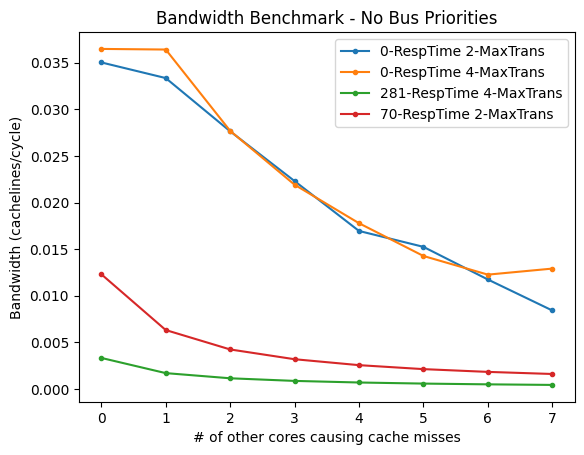

In [30]:
plot_benchmark(data, 'MemConf')

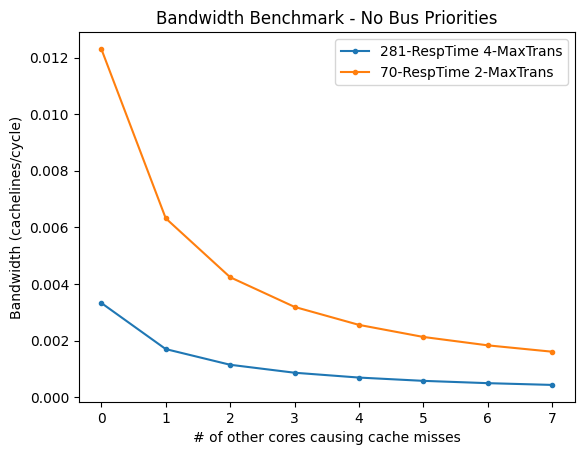

In [31]:
plot_benchmark(data.loc[data["MemResponseTime"] > 0], 'MemConf')